# Section 6a: Job Submissions, Runtime and Energy

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import matplotlib.image as mpimg

In [3]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [4]:
df_prom_slurm = spark.read.parquet(path_job_node_joined_dataset)
df_prom_slurm = df_prom_slurm.withColumn("job_duration_seconds", F.unix_timestamp('end_date') - F.unix_timestamp('start_date'))
df_prom_slurm = df_prom_slurm.orderBy('prom_id', 'timestamp')
df_prom_slurm.show(5, False)

24/05/03 22:32:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-----+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+--------------------------

Job submissions

In [5]:
df_prom_slurm_submissions = df_prom_slurm.groupBy('slurm_id').agg(
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state'),
).groupBy('gpu_node', 'state').agg(F.count(F.lit(1)).alias('submissions')).orderBy('gpu_node', 'state')

df_prom_slurm_submissions.show(20, False)

+--------+-------------+-----------+
|gpu_node|state        |submissions|
+--------+-------------+-----------+
|0       |CANCELLED    |9354       |
|0       |COMPLETED    |197007     |
|0       |FAILED       |36138      |
|0       |NODE_FAIL    |1426       |
|0       |OUT_OF_MEMORY|4512       |
|0       |TIMEOUT      |10426      |
|1       |CANCELLED    |3654       |
|1       |COMPLETED    |17493      |
|1       |FAILED       |4612       |
|1       |NODE_FAIL    |103        |
|1       |OUT_OF_MEMORY|126        |
|1       |TIMEOUT      |1407       |
+--------+-------------+-----------+



Job Runtimes

In [6]:
df_prom_slurm_job_runtimes = df_prom_slurm.groupBy('slurm_id').agg(
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state'),
    F.first('job_duration_seconds').alias('job_duration_seconds')
).groupBy('gpu_node', 'state').agg(
    F.sum('job_duration_seconds').alias('job_runtime_seconds_total')
).orderBy('gpu_node', 'state')

df_prom_slurm_job_runtimes.show(20, False)

+--------+-------------+-------------------------+
|gpu_node|state        |job_runtime_seconds_total|
+--------+-------------+-------------------------+
|0       |CANCELLED    |159046737                |
|0       |COMPLETED    |1173105305               |
|0       |FAILED       |104156032                |
|0       |NODE_FAIL    |50619879                 |
|0       |OUT_OF_MEMORY|20356990                 |
|0       |TIMEOUT      |534363989                |
|1       |CANCELLED    |70774931                 |
|1       |COMPLETED    |208591299                |
|1       |FAILED       |19229486                 |
|1       |NODE_FAIL    |831895                   |
|1       |OUT_OF_MEMORY|2247041                  |
|1       |TIMEOUT      |111323897                |
+--------+-------------+-------------------------+



Job Energy

In [7]:
df_prom_slurm_energy = df_prom_slurm.join(
    df_prom_slurm.groupBy('node', 'timestamp').agg(F.count(F.lit(1)).alias('concurrent_job_count')), ['node', 'timestamp'], how='left'
).withColumn('node_power_usage_per_job_per_node_per_timestamp', col('node_power_usage') / col('concurrent_job_count')) \
.groupBy('slurm_id', 'node').agg(
    F.mean('node_power_usage_per_job_per_node_per_timestamp').alias('node_power_usage_per_job_per_node_mean'),
    F.first('job_duration_seconds').alias('job_duration_seconds'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).withColumn('node_energy_usage_per_job_per_node', F.col('node_power_usage_per_job_per_node_mean') * F.col('job_duration_seconds')) \
.groupBy('slurm_id').agg(
    F.sum('node_energy_usage_per_job_per_node').alias('node_energy_usage_per_job'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).groupBy('gpu_node', 'state').agg(
    F.sum('node_energy_usage_per_job').alias('node_energy_usage_per_nodetype_per_state')
).orderBy('gpu_node', 'state')

df_prom_slurm_energy.show(20, False)

+--------+-------------+----------------------------------------+
|gpu_node|state        |node_energy_usage_per_nodetype_per_state|
+--------+-------------+----------------------------------------+
|0       |CANCELLED    |2.608609018815528E10                    |
|0       |COMPLETED    |1.3324333832321936E11                   |
|0       |FAILED       |1.0481751835618128E10                   |
|0       |NODE_FAIL    |7.462965993926804E9                     |
|0       |OUT_OF_MEMORY|2.1906713201444945E9                    |
|0       |TIMEOUT      |8.387906954013939E10                    |
|1       |CANCELLED    |2.924674181218663E10                    |
|1       |COMPLETED    |8.089752397592166E10                    |
|1       |FAILED       |7.764930356570924E9                     |
|1       |NODE_FAIL    |4.3113557045639735E8                    |
|1       |OUT_OF_MEMORY|1.765528827909534E9                     |
|1       |TIMEOUT      |4.744951799582663E10                    |
+--------+

Join all submisions, runtimes and energy dataframes

In [8]:
df_prom_slurm_sub_run_energy = df_prom_slurm_submissions.join(
    df_prom_slurm_job_runtimes, ['gpu_node', 'state'], 'inner').join(df_prom_slurm_energy, ['gpu_node', 'state'], 'inner'
).orderBy('gpu_node', 'state')

df_prom_slurm_sub_run_energy.show(20, False)

+--------+-------------+-----------+-------------------------+----------------------------------------+
|gpu_node|state        |submissions|job_runtime_seconds_total|node_energy_usage_per_nodetype_per_state|
+--------+-------------+-----------+-------------------------+----------------------------------------+
|0       |CANCELLED    |9354       |159046737                |2.608609018815528E10                    |
|0       |COMPLETED    |197007     |1173105305               |1.3324333832321936E11                   |
|0       |FAILED       |36138      |104156032                |1.0481751835618128E10                   |
|0       |NODE_FAIL    |1426       |50619879                 |7.462965993926804E9                     |
|0       |OUT_OF_MEMORY|4512       |20356990                 |2.1906713201444945E9                    |
|0       |TIMEOUT      |10426      |534363989                |8.387906954013939E10                    |
|1       |CANCELLED    |3654       |70774931                 |2.

In [9]:
df_prom_slurm_sub_run_energy_pd = df_prom_slurm_sub_run_energy.toPandas()

df_prom_slurm_sub_run_energy_pd = df_prom_slurm_sub_run_energy_pd.rename(
    columns={'submissions': 'Job Submissions', 'job_runtime_seconds_total': 'Job Runtime', 'node_energy_usage_per_nodetype_per_state': 'Job Energy Usage'}
    )

df_prom_slurm_sub_run_energy_pd

,gpu_node,state,Job Submissions,Job Runtime,Job Energy Usage
0,0,CANCELLED,9354,159046737,2.608609e+10
1,0,COMPLETED,197007,1173105305,1.332433e+11
2,0,FAILED,36138,104156032,1.048175e+10
3,0,NODE_FAIL,1426,50619879,7.462966e+09
4,0,OUT_OF_MEMORY,4512,20356990,2.190671e+09
5,0,TIMEOUT,10426,534363989,8.387907e+10
6,1,CANCELLED,3654,70774931,2.924674e+10
7,1,COMPLETED,17493,208591299,8.089752e+10
8,1,FAILED,4612,19229486,7.764930e+09
9,1,NODE_FAIL,103,831895,4.311356e+08


In [10]:
def plot_horizontal_stacked_bar_with_hatches(df, columns, file_path, ax=None, plot_legend=True):

    df_pd = df.copy()
    plt.figure(figsize=(14, 14))

    for c in columns:
        df_pd[c] = df_pd[c] / df_pd[c].sum()

    df_pd.set_index('state', inplace=True, drop=True)
    display(df_pd)

    df_pd = df_pd[df_pd.columns[::-1]]
    df_pd = df_pd.drop(columns='gpu_node')
    df_pd = df_pd.T

    column_order = ['COMPLETED', 'FAILED', 'CANCELLED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL']
    df_pd = df_pd[column_order]

    colors = sns.color_palette('colorblind', n_colors=len(column_order))
    width = 0.75

    if ax is None:
        ax = df_pd.plot(kind='barh', stacked=True, color=colors, width=width)
    else:
        df_pd.plot(kind='barh', stacked=True, color=colors, ax=ax, width=width)

    hatches = ['.', '/', '+', '\\', '*', 'x']

    # Add hatch patterns to the bars
    for i, bar in enumerate(ax.patches):
        # For every possible job state, 2 subsequent bars are created in ax.patches, one for each job type (generic, ML)
        # Set bars pairwise (same job state) to the same hatch pattern
        bar.set_hatch(hatches[i // len(columns)])

    plt.xlabel("Fraction of total Values")
        
    if plot_legend:
        # reorder legend entries
        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
        labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]
        ax.legend(handles, labels, title='Job State', ncol=3, loc='upper center', bbox_to_anchor=(0.4, 1.9))
    else:
        ax.get_legend().remove()


    plt.savefig(f'{file_path}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{file_path}.pdf', bbox_inches='tight')

    plt.show()

,gpu_node,Job Submissions,Job Runtime,Job Energy Usage
state,,,,
CANCELLED,0,0.036135,0.077901,0.099057
COMPLETED,0,0.761047,0.574587,0.505967
FAILED,0,0.139603,0.051016,0.039803
NODE_FAIL,0,0.005509,0.024794,0.028339
OUT_OF_MEMORY,0,0.017430,0.009971,0.008319
TIMEOUT,0,0.040276,0.261732,0.318515


<Figure size 1400x1400 with 0 Axes>

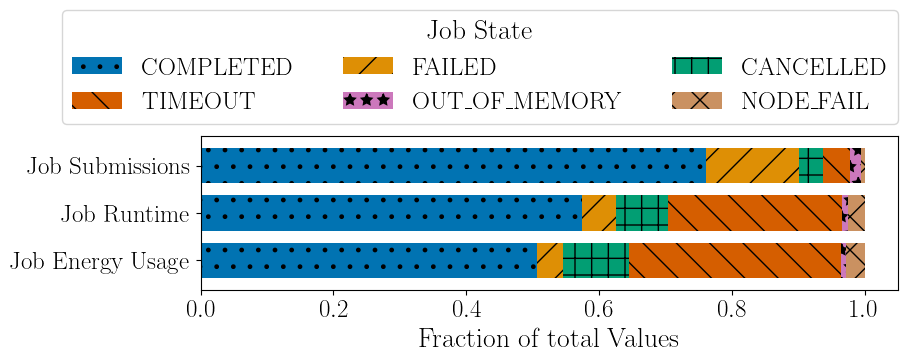

In [11]:
set_one_column_figure_font(height_multiplier=0.40)

df_prom_slurm_sub_run_energy_pd_generic = df_prom_slurm_sub_run_energy_pd[df_prom_slurm_sub_run_energy_pd['gpu_node'] == 0]
plot_horizontal_stacked_bar_with_hatches(df_prom_slurm_sub_run_energy_pd_generic, columns=df_prom_slurm_sub_run_energy_pd_generic.columns[-3:], file_path='plots/section_6/job_submissions_runtime_energy_generic', plot_legend=True)

,gpu_node,Job Submissions,Job Runtime,Job Energy Usage
state,,,,
CANCELLED,1,0.133382,0.171368,0.174550
COMPLETED,1,0.638547,0.505065,0.482811
FAILED,1,0.168352,0.046561,0.046342
NODE_FAIL,1,0.003760,0.002014,0.002573
OUT_OF_MEMORY,1,0.004599,0.005441,0.010537
TIMEOUT,1,0.051360,0.269550,0.283187


<Figure size 1400x1400 with 0 Axes>

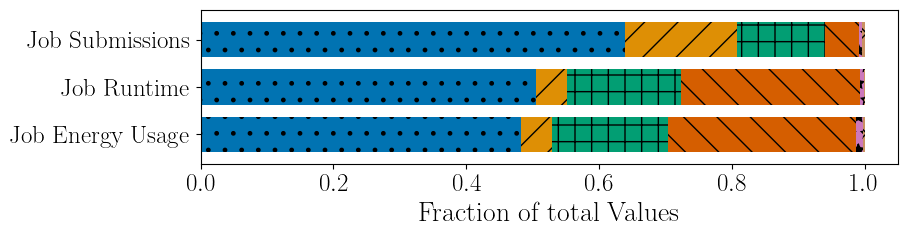

In [12]:
set_one_column_figure_font(height_multiplier=0.40)

df_prom_slurm_sub_run_energy_pd_ml = df_prom_slurm_sub_run_energy_pd[df_prom_slurm_sub_run_energy_pd['gpu_node'] == 1]
plot_horizontal_stacked_bar_with_hatches(df_prom_slurm_sub_run_energy_pd_ml, columns=df_prom_slurm_sub_run_energy_pd_ml.columns[-3:], file_path='plots/section_6/job_submissions_runtime_energy_ml', plot_legend=False)